## Some stats and graph about Airbnb presence in Bologna, Italy. 

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

### I'm going to use the Inside Airbnb's data (http://insideairbnb.com/ by Murray Cox) and some older data scraped by Tom Slee (http://tomslee.net/category/airbnb-data). I will mainly use pandas package, then matplotlib and seaborn for visualization. 

### As first, I'm going to take all my csv files, doing easy pre-processing and make them consistent. Of course, using only Inside Airbnb data should make this process less annoying.

In [10]:
# all my csv!
files = [i for i in os.listdir('bologna') if i.endswith('.csv')]


# Initializing all csv files as a pandas dataframe
def setup(datalist):
    
    dfs = []
    for i in datalist:  
        try:
            dfs.append(pd.read_csv("bologna/" + str(i)))
        except UnicodeDecodeError:
            print(i)
    
    return dfs     

dfs = setup(files)

# Normalizing column spelling across different dataframes    
for df in dfs:
    if "neighborhood" in df.columns:
        df["neighbourhood"] = df.neighborhood
        del df["neighborhood"]
        

# Creating a list of pandas datetimes from the filenames 
def timestamps(datalist):
    periods = []
    for i in datalist:
        y = i.split(".")[0].split("_")[1]
        m = i.split(".")[0].split("_")[0]
        d = 1
        date = str(y) + "-" + str(m) + "-" + str(d)
        date = pd.Timestamp(date)
        periods.append(date)
    return periods

periods = timestamps(files)


# Sorting dataframes by date
tmp = [(d,p) for d,p in sorted(zip(dfs,periods), key=lambda pair: pair[1])]
periods = [b for a,b in tmp]
dfs = [a for a,b in tmp]
    
    
## then check out if everything went well 
assert(len(periods) == len(dfs))

### Let's make an overview on hosts number in each dataset. We can easily notice that the global number of hosts and announces grows over time, as long as the mean of announces per host and the standard deviation. 

In [11]:
def overview_hosts_ids(dataset, data):
    try:
        print(f'Host statistics on {data}:')
        print(dataset['host_id'].value_counts().describe())
        print(f"Global nb of announces: {dataset['id'].count()}")
        print()
    except:
        pass
    
for i,df in enumerate(dfs):
    overview_hosts_ids(df, periods[i])#.strftime('%Y/%m'))

Host statistics on 2017-04-01 00:00:00:
count    2079.000000
mean        1.431457
std         1.981384
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        74.000000
Name: host_id, dtype: float64
Global nb of announces: 2976

Host statistics on 2018-06-01 00:00:00:
count    2206.000000
mean        1.517679
std         2.062604
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        64.000000
Name: host_id, dtype: float64
Global nb of announces: 3348

Host statistics on 2018-07-01 00:00:00:
count    2310.000000
mean        1.529437
std         2.115698
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        66.000000
Name: host_id, dtype: float64
Global nb of announces: 3533

Host statistics on 2018-08-01 00:00:00:
count    2344.000000
mean        1.526451
std         2.109908
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      

### That probably means that multihosts (hosts with more than one announce on Airbnb) tent to increase over time, whereas single-hosts decrease. Besides, the standard deviation trend make me think that the augmentation especially involves those hosts who have 2,3 or 4 announces,rather than the very big players (people with more than 10 announces).

### Let's do a lineplot to visualize general trends over time. As first, we're going to check out the growth of host/announce number, against the announces of private/shared rooms.

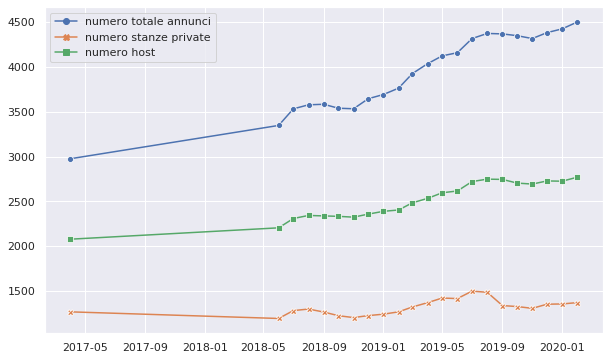

In [12]:
def snsplot(lines):
    sns.set(style="darkgrid")
    plt.figure(figsize=(10,6))
    sns.lineplot(markers=True, dashes=False, data=lines)


def ids_during_time(dfs, periods):
    index = pd.DatetimeIndex(periods)

    id_count = pd.Series([dfs[i].id.count() for i in range(len(dfs))], index=index)
    private_room_count = pd.Series([dfs[i][dfs[i].room_type.isin(["Private room", "Shared room"])].id.count() for i in range(len(dfs))], index=index)
    host_count = pd.Series([len(set(dfs[i].host_id)) for i in range(len(dfs))], index=index)

    lines = id_count.rename("numero totale annunci").to_frame()\
        .join(private_room_count.rename("numero stanze private").to_frame())\
        .join(host_count.rename("numero host").to_frame())
    
    snsplot(lines)
    
ids_during_time(dfs, periods)

### It's easy to notice that the growth trend it's way lower for the private / shared rooms announces, compared to the entire apartment / home announces. Let's do a focus on that:

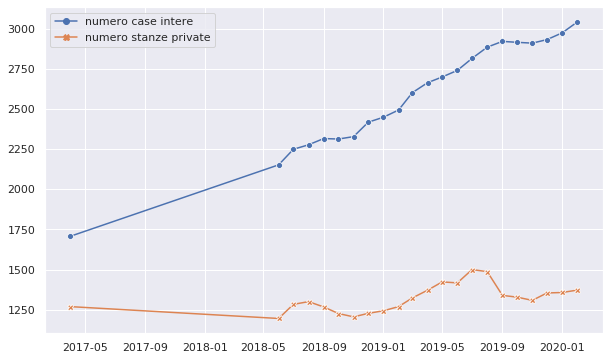

In [13]:
def type_of_room_during_time(dfs, periods):
    index = pd.DatetimeIndex(periods)

    entire_home_count = pd.Series([dfs[i][dfs[i].room_type.isin(["Entire home/apt"])].id.count() for i in range(len(dfs))], index=index)
    private_room_count = pd.Series([dfs[i][dfs[i].room_type.isin(["Private room", "Shared room"])].id.count() for i in range(len(dfs))], index=index)

    lines = entire_home_count.rename("numero case intere").to_frame()\
        .join(private_room_count.rename("numero stanze private").to_frame())
    
    snsplot(lines)


type_of_room_during_time(dfs, periods)

### Here below I removed 2016 / 2017 data so that I can focus the period where I have more time granularity (namely July 2018, when Inside Airbnb started doing regular uploads of Bologna's data. 

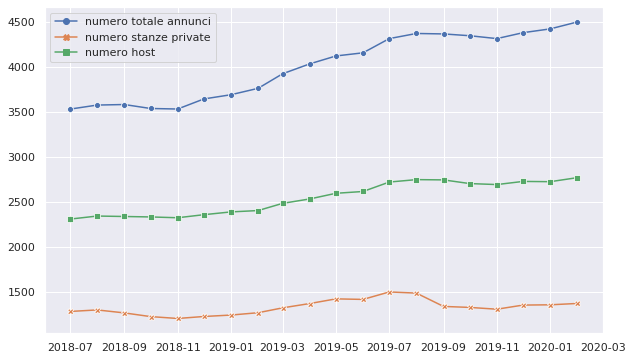

In [14]:
for i in range(2):
    periods.pop(0)
    dfs.pop(0)

ids_during_time(dfs, periods)

### Announces of entire apartments or houses have a stronger impact on city demography, since that means that those houses are entirely dedicated to tourism (there's no inhabitant living there), and they are taken off from real estate market.

### Looking carefully at data, we can notice that not all the announces are active on the platform: plenty of them have no recent review or no review at all (they've probably been uploaded shortly before the Inside Airbnb 'photo'). I tried to take this announces off (choosing a threshold of 6 months for the last review) and voilà: 

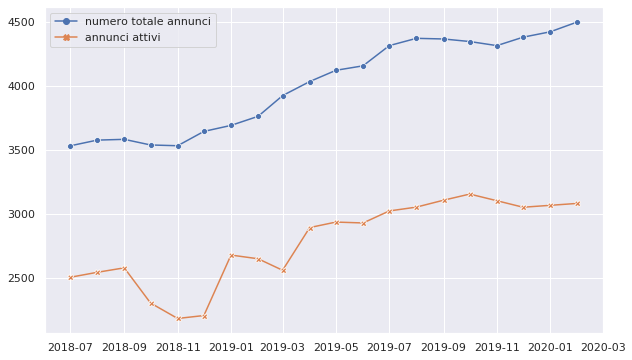

In [15]:
# transforming column 'last_review' in pandas datetimes objects 
for df in dfs:
    df['last_review'] = df['last_review'].astype('datetime64[ns]')
    
    
def active_announces(d, i, periods=periods):  
    threshold =  periods[i] - pd.DateOffset(months=6)
    idCount_oldreviews = d[d.last_review < threshold]
    idCount_inactive = d[d.number_of_reviews == 0]
    return (len(d) - (len(idCount_oldreviews) + len(idCount_inactive)))

index = pd.DatetimeIndex(periods)

idCount_total = pd.Series([df.id.count() for df in dfs], index=index)
idCount_active = pd.Series([active_announces(df, i) for i, df in enumerate(dfs)], index=index)

lines = idCount_total.rename("numero totale annunci").to_frame()\
        .join(idCount_active.rename("annunci attivi").to_frame())

snsplot(lines)

### It turns out that global number of announces is way overestimated. However, our criterion to select active announces relies on reviews, which is quite approximate: not all users leave a review after a stay. In this case, the total number of active announces is probably slightly higher, while I've no clue of way there's a bending between September 2018 and January 2019.  

### Let's analyse prices. As first, I thought to remove outliers, namely those prices that seem too far from the average prices. Down here we can see some example, under the column 'price':

In [16]:
dfs[-1].sort_values(ascending=False, by=['price']).head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
3390,34619334,FlatinBo Apartaments via De' Carracci- Zues,50429991,Flat In Italy,NaN,Navile,44.50985,11.33123,Hotel room,9999,1,5,2019-08-31,0.60,15,0
867,12342253,Cozy studio apartment in Saragozza,29414872,Emanuele,NaN,Porto - Saragozza,44.49040,11.31955,Entire home/apt,8534,1,7,2018-03-28,0.16,1,0
4283,41237296,Luxury Attic Jacuzzi a sfioro Vasca Ovale & Ca...,323693833,Alessandro,NaN,Porto - Saragozza,44.49772,11.33906,Entire home/apt,5000,1,0,NaT,NaN,1,0
4008,39690694,FlatinBO apartments Stazione Centrale- L. Costa,50429991,Flat In Italy,NaN,Navile,44.50984,11.34474,Entire home/apt,5000,1,2,2019-11-11,0.58,15,93
4337,41544623,MOONLIGHT CENTRO BOLOGNA,136592569,Yodit,NaN,Santo Stefano,44.48786,11.35363,Entire home/apt,2500,1,0,NaT,NaN,5,180


### 9999 euros seems to be an inconsistent price, ok. But what about 5000? Could it be an informal price per month? If so, do they deposit a regular rent contract? Is there any economical benefit to rent a house monthly through Airbnb instead of using traditional channels? Something to look into... 

### Let's remove the outliers. I weight the price with the number of days in which the announce is available, then I exclude the ones that fall off the 97° percentile.

In [17]:
def remove_outliers(period):
    x = period['price'] * period['availability_365'] / 365
    period["price_pond"] = x
    return period[x.between(x.quantile(.0001), x.quantile(.98))]

dfs = [remove_outliers(i) for i in dfs]


# formatting datetimes for better captions...

periods_2 = [i.strftime('%Y/%m') for i in periods]

### The next 2 charts show the gap between the biggest players (the top 5 % of hosts with more announces) and those with a single announce (about three quarters of total users). The host-announce distribution draws a sort of zipf curve: very few hosts with a lot of announces, and a long tail of unique-announce hosts. 

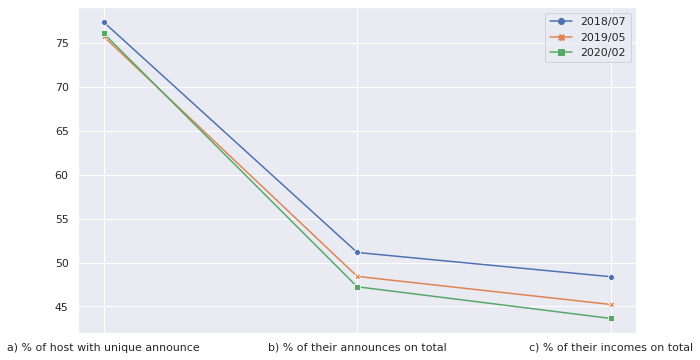

In [18]:

def three_val(dfs=dfs):
    return (0, round(len(dfs) / 2), -1)

def single_host(period):        
        a = period[period.calculated_host_listings_count == 1]

        percentIncomes = a.price.sum() * 100 / period.price.sum()
        percentAnnounces = a.id.count() * 100 / period.id.count()
        percentHost = len(a.host_id.value_counts()) * 100 / len(period.host_id.value_counts())
        
        return pd.Series([percentHost, percentAnnounces, percentIncomes])

def plotting(a,b,c,thrval,x,periods=periods_2):
        lines = a.rename(periods[thrval[0]]).to_frame()\
        .join(b.rename(periods[thrval[1]]).to_frame())\
        .join(c.rename(periods[thrval[2]]).to_frame()).set_index(x)

        snsplot(lines)
        
def scissor_1(thrval, periods=periods_2):
    a = single_host(dfs[thrval[0]])
    b = single_host(dfs[thrval[1]])
    c = single_host(dfs[thrval[2]])
    x = pd.Series(["a) % of host with unique announce","b) % of their announces on total","c) % of their incomes on total"])
    plotting(a,b,c,thrval,x)
    
scissor_1(three_val())

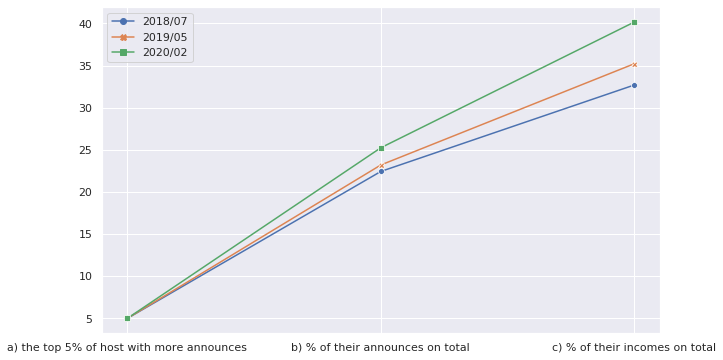

In [19]:
def incomes_rate(period, nHosts):
    
    g = period.groupby("host_id")['price_pond'].sum().sort_values(ascending=False)
    h = period.groupby("host_id")['id'].count().sort_values(ascending=False)
    
    percentAnnounces = h[:nHosts].sum() * 100 / period.id.count()
    percentIncomes = g[:nHosts].sum() * 100 / g.sum() 
    
    return pd.Series([5, percentAnnounces, percentIncomes])

def five_percent(period):          
    return int(round(len(period["host_id"].value_counts()) / 20))

def scissor_2(thrval, periods=periods_2):

    a = incomes_rate(dfs[thrval[0]], five_percent(dfs[thrval[0]]))
    b = incomes_rate(dfs[thrval[1]], five_percent(dfs[thrval[1]]))
    c = incomes_rate(dfs[thrval[2]], five_percent(dfs[thrval[2]]))

    x = pd.Series(["a) the top 5% of host with more announces", "b) % of their announces on total" ,"c) % of their incomes on total"])

    plotting(a,b,c,thrval,x)
    
scissor_2(three_val())

### Next, a couple of barplots that show prices and announces count trends over time per neighbourhood.

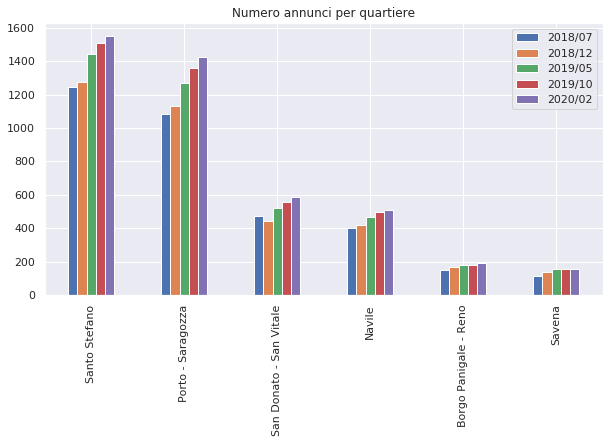

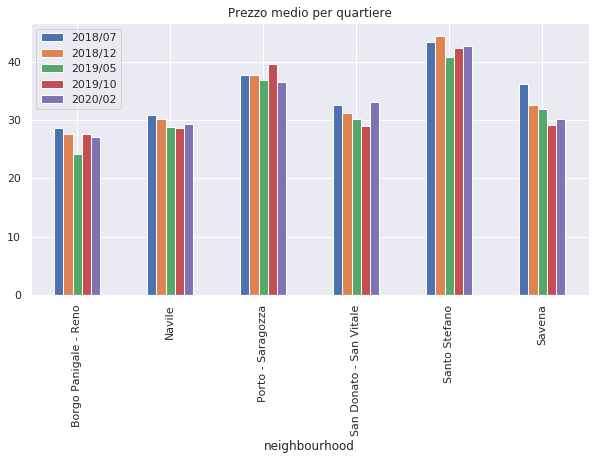

In [20]:
def five_val(dfs=dfs):
    median = round(len(dfs) / 2)
    second = round(round(len(dfs) / 2) / 2)
    fourth = median + second
    return [0, second, median, fourth, -1]

def plotting(series, title, i=five_val(), dfs=dfs, periods=periods_2):
    
    graph_df = series[0].rename(periods[i[0]]).to_frame()\
    .join(series[1].rename(periods[i[1]]).to_frame())\
    .join(series[2].rename(periods[i[2]]).to_frame())\
    .join(series[3].rename(periods[i[3]]).to_frame())\
    .join(series[4].rename(periods[i[4]]).to_frame())
    graph_df.plot(kind='bar',figsize=(10, 5), title=title)
    
def neigh_id_count(ils=five_val(), dfs=dfs):
    return [dfs[i]['neighbourhood'].value_counts(normalize=False) for i in ils]

def neigh_average_price(ils=five_val(), dfs=dfs):
    return [dfs[i].groupby("neighbourhood")['price_pond'].mean() for i in ils]
        

plotting(neigh_id_count(), "Numero annunci per quartiere")
plotting(neigh_average_price(), "Prezzo medio per quartiere")

### And that's all for now! Please feel free to write me in case you find any relevant flaw in statistics. I really hope someone could find this code useful to analyse other cities datasets. Ciao!